In [1]:
%matplotlib inline 

# Association Rule Mining
***

## Table of Contents
***
* [Aim](#aim)
* [Code Setup](#code-setup)
* [Data Import](#data-import)

## Aim <a class="anchor" id="aim"></a>
***

The aim of this notebook is to perform Association Rule Mining on the Instacart Data

## Code Setup <a class="anchor" id="code-setup"></a>
***

### Constants

In [2]:
instacart_dir = "instacart_2017_05_01/"
my_orders_file = "my_orders.csv"
products_file = "products.csv"
aisles_file = "aisles.csv"
departments_file = "departments.csv"
orders_products_prior_file = "my_order_products__prior.csv"
orders_products_train_file = "my_order_products__train.csv"

### Import Libraries

In [3]:
import pandas as pd
import sys
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
import seaborn as sns
sns.set_style("darkgrid")
sns.set_context("paper")
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [4]:
te = TransactionEncoder()

In [5]:
def read_csv_file(file_name):
    return pd.read_csv(instacart_dir + file_name)

In [6]:
orders = read_csv_file(my_orders_file)
orders.head()

,Unnamed: 0,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,12202,472199,765,prior,1,2,21,NaN
1,12203,1424394,765,prior,2,1,21,20.0
2,12204,889292,765,prior,3,6,21,30.0
3,12205,2809253,765,prior,4,3,20,30.0
4,12206,2392861,765,prior,5,1,12,19.0


In [7]:
orders_products_prior = read_csv_file(orders_products_prior_file)
orders_products_train = read_csv_file(orders_products_train_file)
orders_products = pd.concat([orders_products_prior, orders_products_train])
orders_products.head()

,Unnamed: 0,order_id,product_id,add_to_cart_order,reordered
0,147221,15511,429,1,0
1,147222,15511,46397,2,0
2,147223,15511,27323,3,0
3,147224,15511,28842,4,1
4,147225,15511,4605,5,0


In [8]:
products = read_csv_file(products_file)
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [9]:
departments = read_csv_file(departments_file)
departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [10]:
aisles = read_csv_file(aisles_file)
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


### Product Number Counts

In [11]:
product_order_frequency = (orders_products
                           .groupby("product_id")
                           .size()
                           .reset_index(name="count")
                           .sort_values(by=['count'], ascending=False)
                          )
order_count_total = orders.shape[0]
print("Total Orders :", order_count_total)
max_product_count = product_order_frequency["count"].max()
min_product_count = product_order_frequency["count"].min()
print("Product Order Count Max :", max_product_count)
print("Product Order Count Min :", min_product_count)
mean_order_frequency = round(product_order_frequency["count"].mean())
print("Product Order Count Average :", mean_order_frequency)
print("Product Order Count Median :", product_order_frequency["count"].median())
print("Product Order Count Mode :", product_order_frequency["count"].mode()[0])

Total Orders : 306
Product Order Count Max : 67
Product Order Count Min : 1
Product Order Count Average : 3.0
Product Order Count Median : 1.0
Product Order Count Mode : 1


### Products Not Ordered Often

In [12]:
# Originally wanted 10 but only left about 40 products so suck it and see approach
min_desired_times_ordered = 5
least_orderer_products = product_order_frequency.query("count <= " + str(min_desired_times_ordered))
least_orderer_products.head()

,product_id,count
205,11422,5
587,30391,5
175,10132,5
660,33731,5
195,10768,5


### Often Ordered Products

In [13]:
# Only dropping the product entry from the order, not the whole order
often_orders_products =  product_order_frequency[~product_order_frequency['product_id'].isin(least_orderer_products.product_id.tolist())]
print("Number of often ordered products :", often_orders_products.shape[0])
often_orders_products.head()

Number of often ordered products : 107


,product_id,count
772,40174,67
84,4942,53
159,9387,42
478,24852,39
415,22124,30


### Often Ordered Products Detail

In [14]:
products_ordered_count = often_orders_products.merge(products, on="product_id")
products_ordered_count.head()

,product_id,count,product_name,aisle_id,department_id
0,40174,67,2% Reduced Fat Organic Milk,84,16
1,4942,53,Vanilla Almond Breeze,91,16
2,9387,42,Granny Smith Apples,24,4
3,24852,39,Banana,24,4
4,22124,30,Total 0% Raspberry Yogurt,120,16


### Grouping Products in an Order - Frequent Itemsets

In [15]:
# Can't just use a comma as a seperator
products_ordered = orders_products[orders_products['product_id'].isin(products_ordered_count.product_id.tolist())]
products_ordered = products_ordered.merge(products, on="product_id")
weird_separator = ",#,"
products_ordered_total = (products_ordered.groupby('order_id')['product_name']
                          .apply(lambda x: "%s" % weird_separator.join(x))
                          .reset_index(name='products')
                         )
order_total_remaining = products_ordered_total.shape[0]
print("Number of orders left to analyse :", order_total_remaining)
print("Number of distinct products in remaining orders :", products_ordered_count.shape[0])
products_ordered_total.head()

Number of orders left to analyse : 252
Number of distinct products in remaining orders : 107


,order_id,products
0,15511,"Bunched Cilantro,#,Yellow Onions"
1,27068,"Yellow Onions,#,Red Peppers,#,Yellow Bell Pepp..."
2,49162,"Bunched Cilantro,#,Red Peppers,#,Yellow Bell P..."
3,54312,"Organic Apple Juice Boxes,#,Firm Tofu,#,Organi..."
4,63012,"S'mores Chocolate Ice Cream,#,Cherry Vanilla C..."


### Calculate Decent Support Value

In [16]:
# For support values
min_support = round(min_desired_times_ordered/order_total_remaining, 4)
print("Minimum times ordered to be considered :", min_desired_times_ordered)
print("Minimum Support :", min_support)

Minimum times ordered to be considered : 5
Minimum Support : 0.0198


### Transaction Database Boolean Array

In [17]:
products_ordered_list = products_ordered_total.products.tolist()
products_ordered_list_of_lists = []
for p in products_ordered_list:
    products_ordered_list_of_lists.append(p.split(weird_separator))
te_ary = te.fit(products_ordered_list_of_lists).transform(products_ordered_list_of_lists,sparse=False)
te_df = pd.DataFrame(te_ary, columns=te.columns_)
te_df.head()

,100% Whole Wheat Bread,2% Reduced Fat Organic Milk,Asparagus,Baby Arugula,Bag of Organic Bananas,Banana,Beer,Boneless Skinless Chicken Breasts,Brown Fertile Large Grade AA Eggs,Bunched Cilantro,...,Total 2% Greek Strained Yogurt with Cherry 5.3 oz,Total 2% Lowfat Greek Strained Yogurt With Blueberry,Total 2% with Strawberry Lowfat Greek Strained Yogurt,Vanilla Almond Breeze,White Corn,Whole Grains Health Nut Bread,XL Emerald White Seedless Grapes,Yellow Bell Pepper,Yellow Onions,Yogurt Tubes Blueberry
0,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,True,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False
2,False,False,False,False,False,False,False,True,False,True,...,False,False,False,False,False,False,False,True,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [18]:
frequent_itemsets = (apriori(te_df, min_support=min_support,use_colnames=True)
     .sort_values(by='support',ascending=False))
print("Number of frequent itemsets generated via Apriori with over ", min_support, " support :" , frequent_itemsets.shape[0])
frequent_itemsets.head()

Number of frequent itemsets generated via Apriori with over  0.0198  support : 643


,support,itemsets
1,0.265873,[2% Reduced Fat Organic Milk]
100,0.210317,[Vanilla Almond Breeze]
134,0.198413,"[2% Reduced Fat Organic Milk, Vanilla Almond B..."
25,0.166667,[Granny Smith Apples]
5,0.154762,[Banana]


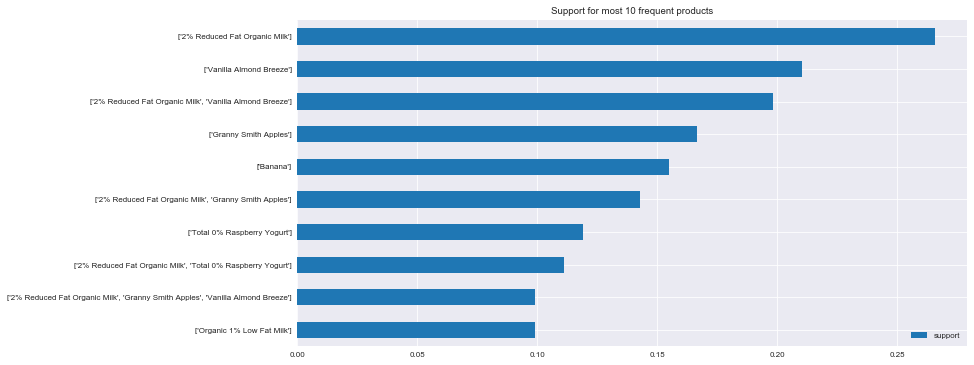

In [19]:
min_numer_to_show = 10
frequent_itemsets.head(min_numer_to_show).plot.barh(title ="Support for most " + str(min_numer_to_show) +  " frequent products")
plt.yticks(range(min_numer_to_show), frequent_itemsets["itemsets"].head(min_numer_to_show))
plt.gca().invert_yaxis()
plt.show()

### Rule Generation

####  Rule Generation by Lift

In [20]:
min_lift = 5
lift_rules = (association_rules(frequent_itemsets, metric="lift", min_threshold=min_lift)
        .sort_values(by=['confidence', 'support'],ascending=False))
print ("Number of Generated Rules via lift :", lift_rules.shape[0], " min value of lift : ", min_lift)
lift_rules.head()

Number of Generated Rules via lift : 3114  min value of lift :  5


,antecedants,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
39,"(Vanilla Almond Breeze, 2% Reduced Fat Organic...",(Total 0% Raspberry Yogurt),0.047619,0.119048,0.047619,1.0,8.4,0.041950,inf
41,"(Vanilla Almond Breeze, Total 2% Lowfat Greek ...","(2% Reduced Fat Organic Milk, Total 0% Raspber...",0.047619,0.111111,0.047619,1.0,9.0,0.042328,inf
59,"(Vanilla Almond Breeze, Total 2% Lowfat Greek ...",(Total 0% Raspberry Yogurt),0.047619,0.119048,0.047619,1.0,8.4,0.041950,inf
92,(Premium Lager Beer),(Lager),0.043651,0.047619,0.043651,1.0,21.0,0.041572,inf
153,(Total 2% Greek Strained Yogurt with Cherry 5....,(Total 0% Raspberry Yogurt),0.035714,0.119048,0.035714,1.0,8.4,0.031463,inf


#### Rule Generation by Confidence

In [21]:
min_conf = 0.8
conf_rules = (association_rules(frequent_itemsets, metric="confidence", min_threshold=min_conf)
        .sort_values(by='confidence',ascending=False))
print ("Number of Generated Rules via confidence :", conf_rules.shape[0], " min confidence :", min_conf)
conf_rules.head()

Number of Generated Rules via confidence : 887  min confidence : 0.8


,antecedants,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
443,(Total 2% All Natural Greek Strained Yogurt wi...,"(Vanilla Almond Breeze, Total 2% Greek Straine...",0.023810,0.051587,0.023810,1.0,19.384615,0.022581,inf
309,"(Organic California Style Sprouted Bread, Rose...",(Organic 1% Low Fat Milk),0.023810,0.099206,0.023810,1.0,10.080000,0.021447,inf
321,"(XL Emerald White Seedless Grapes, Total 0% Ra...",(Vanilla Almond Breeze),0.023810,0.210317,0.023810,1.0,4.754717,0.018802,inf
547,"(Spaghetti, Salted Butter, Roasted Garlic Past...","(Banana, Cherry Vanilla Creme Soda)",0.019841,0.027778,0.019841,1.0,36.000000,0.019290,inf
319,"(Vanilla Almond Breeze, Total 0% Peach Yogurt)",(Total 0% Raspberry Yogurt),0.023810,0.119048,0.023810,1.0,8.400000,0.020975,inf


In [22]:
# get stats on objective measures
lift_rules[["support","confidence", "lift"]].describe()

,support,confidence,lift
count,3114.000000,3114.000000,3114.000000
mean,0.024011,0.546316,11.680054
std,0.006524,0.238577,7.450537
min,0.019841,0.100000,5.000000
25%,0.019841,0.367105,7.368421
50%,0.019841,0.500000,9.473684
75%,0.023810,0.714286,13.125000
max,0.071429,1.000000,50.400000


In [23]:
conf_rules[["support","confidence", "lift"]].describe()

,support,confidence,lift
count,887.000000,887.000000,887.000000
mean,0.026252,0.929826,12.544799
std,0.012253,0.077332,12.233763
min,0.019841,0.800000,3.008955
25%,0.019841,0.833333,4.226415
50%,0.023810,1.000000,7.714286
75%,0.027778,1.000000,15.628846
max,0.198413,1.000000,50.400000
